# Tomato leaf disease detection
---
# Prepocesamiento y Arquitectura MobileNetV3



## MobileNetV3: Red eficiente para dispositivos móviles
MobileNetV3 es la tercera generación de la familia MobileNet, diseñada específicamente para dispositivos móviles y sistemas con recursos limitados. Su objetivo es ofrecer modelos de deep learning livianos pero precisos para tareas como clasificación de imágenes, detección de objetos y segmentación semántica.

### Características clave:
- Convoluciones separables en profundidad: Introducidas en MobileNetV1, dividen la convolución tradicional en dos etapas: una por canal (depthwise) y otra de combinación (pointwise). Esto reduce drásticamente el número de operaciones.

- Residuos invertidos y cuellos de botella lineales (MobileNetV2): En lugar de ampliar primero las dimensiones como en otros modelos, se reducen (cuello de botella), se procesan y luego se expanden. Esto mejora la eficiencia manteniendo el rendimiento.

- MobileNetV3 introduce mejoras adicionales:

  - NAS (Neural Architecture Search) consciente del hardware: Automatiza la búsqueda de arquitecturas óptimas según la plataforma (como CPUs móviles).

  - NetAdapt: Ajusta automáticamente las capas del modelo para lograr un equilibrio entre rendimiento y eficiencia.

  - Módulos Squeeze-and-Excite (SE): Mejoran el aprendizaje de características al recalibrar las activaciones por canal.

  - Función de activación H-Swish: Sustituye ReLU para mejorar el rendimiento sin aumentar el coste computacional.


REFERENCIAS
https://medium.com/@RobuRishabh/understanding-and-implementing-mobilenetv3-422bd0bdfb5a


## Descarga
Ve al dataset: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf/data

Haz clic en "Download" Download dataset as zip

#### En Colab, súbelo con:

In [ ]:
from google.colab import files
uploaded = files.upload()  # Selecciona el ZIP descargado

Saving archive.zip to archive.zip


### Descompirmirlo

In [ ]:
import zipfile
import os

filename = 'archive.zip'  #Nombre del archivo descargado

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('tomatoleaf')

### Definición de Rutas y Parámetros de Preprocesamiento
Este bloque define las rutas base para los conjuntos de entrenamiento y validación, y establece los parámetros de entrada que serán usados por el modelo (dimensiones de imagen y tamaño de lote).

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# --- Configuración con pathlib ---
DATASET_PATH = Path("/content/tomatoleaf/tomato")
TRAIN_DATASET = DATASET_PATH / "train"
VAL_DATASET = DATASET_PATH / "val"

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

### Carga y preparación de los conjuntos de entrenamiento y validación

In [ ]:
def cargar_dataset(ruta, shuffle):
    return tf.keras.utils.image_dataset_from_directory(
        ruta,
        label_mode='int',
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )

# Cargar datasets
train_dataset = cargar_dataset(TRAIN_DATASET, shuffle=True)
val_dataset = cargar_dataset(VAL_DATASET, shuffle=False)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


#### Obtener nombres y cantidad de clases

In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Nombre de las clases:", class_names)
print(f"# clases: {num_classes}")


Nombre de las clases: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
# clases: 10


In [ ]:
print(dict(enumerate(class_names)))

{0: 'Tomato___Bacterial_spot', 1: 'Tomato___Early_blight', 2: 'Tomato___Late_blight', 3: 'Tomato___Leaf_Mold', 4: 'Tomato___Septoria_leaf_spot', 5: 'Tomato___Spider_mites Two-spotted_spider_mite', 6: 'Tomato___Target_Spot', 7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 8: 'Tomato___Tomato_mosaic_virus', 9: 'Tomato___healthy'}


## Optimizar el flujo de datos

In [ ]:
# Optimiza el rendimiento del entrenamiento
# cache() evita volver a cargar datos en cada época
# prefetch() prepara el siguiente lote mientras se entrena con el actual
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Arquitectura del modelo con transferencia de aprendizaje
### Basada en MobileNetV3

### Construcción del modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_mobilenetv3_model(input_shape, num_classes):
    # Aumento de datos dentro del modelo
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomZoom(0.3),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ], name="data_augmentation")

    # Carga del modelo base MobileNetV3 preentrenado
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Congelar inicialmente

    # Entrada del modelo
    inputs = tf.keras.Input(shape=input_shape, name="input_image")

    # Pipeline completo
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = tf.keras.layers.Dropout(0.2, name="dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

    # Modelo completo
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MobileNetV3_Classifier")

    return model, base_model

# Crear el modelo
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = 10

model, base_model = build_mobilenetv3_model(input_shape=IMG_SHAPE, num_classes=num_classes)
model.summary()

# Callbacks para entrenamiento
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3)
]

# Descongelar solo las últimas capas para fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV3_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 944,890 (3.60 MB)

 Trainable params: 5,770 (22.54 KB)

 Non-trainable params: 939,120 (3.58 MB)

### Entrenamiento del modelo con callbacks (EarlyStopping y Checkpoint)

In [ ]:
EPOCHS = 20

# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Para etiquetas enteras
    metrics=['accuracy']  # Mide precisión durante el entrenamiento
)

# Callback para guardar el mejor modelo
mejor_modelo_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="modelo_mobilenetv3.keras",
    save_best_only=True,               # Solo guarda si mejora val_accuracy
    monitor='val_accuracy',
    verbose=1
)

# Callback para detener entrenamiento si no mejora
detener_temprano_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,                        # Número de épocas sin mejora antes de detener
    restore_best_weights=True,        # Restaura pesos del mejor modelo
    monitor='val_accuracy',
    verbose=1
)

# Entrenamiento del modelo
historial = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[mejor_modelo_cb, detener_temprano_cb]
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.7110 - loss: 0.8772
Epoch 1: val_accuracy improved from -inf to 0.53500, saving model to modelo_mobilenetv3.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 313s 962ms/step - accuracy: 0.7114 - loss: 0.8760 - val_accuracy: 0.5350 - val_loss: 2.7171
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9153 - loss: 0.2376
Epoch 2: val_accuracy improved from 0.53500 to 0.73700, saving model to modelo_mobilenetv3.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 299s 892ms/step - accuracy: 0.9154 - loss: 0.2376 - val_accuracy: 0.7370 - val_loss: 1.2612
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9389 - loss: 0.1802
Epoch 3: val_accuracy improved from 0.73700 to 0.87000, saving model to modelo_mobilenetv3.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 279s 892ms/step - accuracy: 0.9389 - loss: 0.1801 - val_accuracy: 0.8700 - val_loss: 0.4588
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.9507 - loss: 0.14

# Gráfico / Métrica

### ¿Qué tan bien predice el modelo? Ejemplos visuales
Objetivo
	Ver ejemplos acertados y fallidos visualmente


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


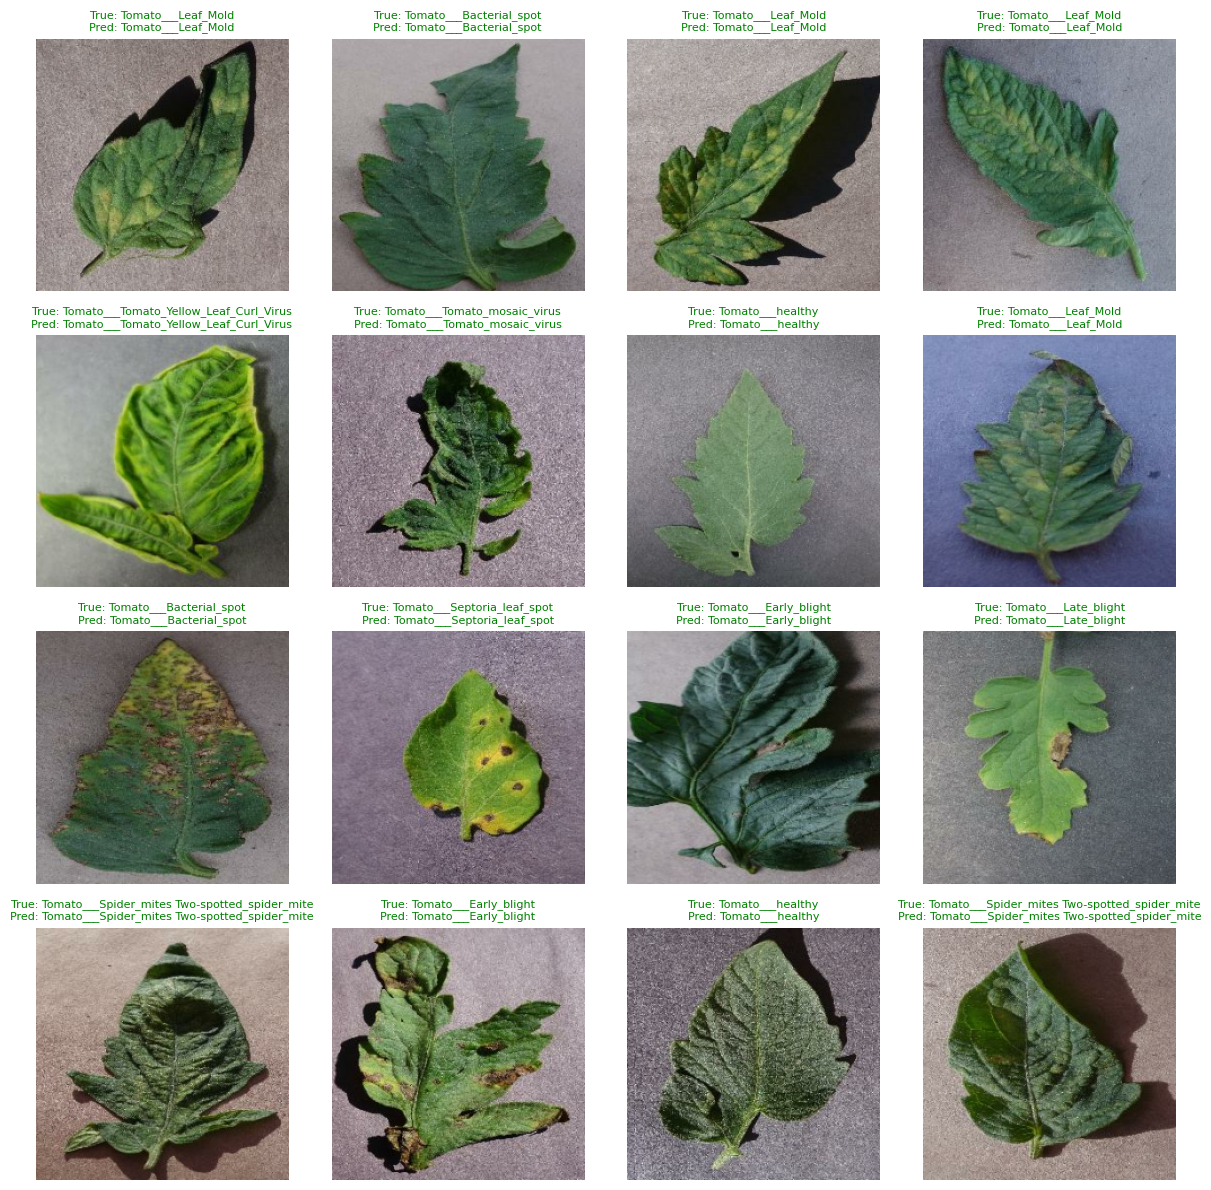

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Carga los pesos del mejor modelo
model.load_weights("modelo_mobilenetv3.keras")

# Toma un batch aleatorio del dataset de validación
for images, labels in train_dataset.shuffle(1000).take(1):
    predictions = model.predict(images)

    plt.figure(figsize=(12, 12))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        pred_index = np.argmax(predictions[i])
        pred_class = class_names[pred_index]
        true_class = class_names[labels[i]]

        color = "green" if pred_class == true_class else "red"
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color, fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## Accuracy y Loss (gráfica por época)
Objetivo: ver si el modelo aprende o se estanca.

Gráfica:

- Accuracy (entrenamiento vs validación)

- Loss (entrenamiento vs validación)

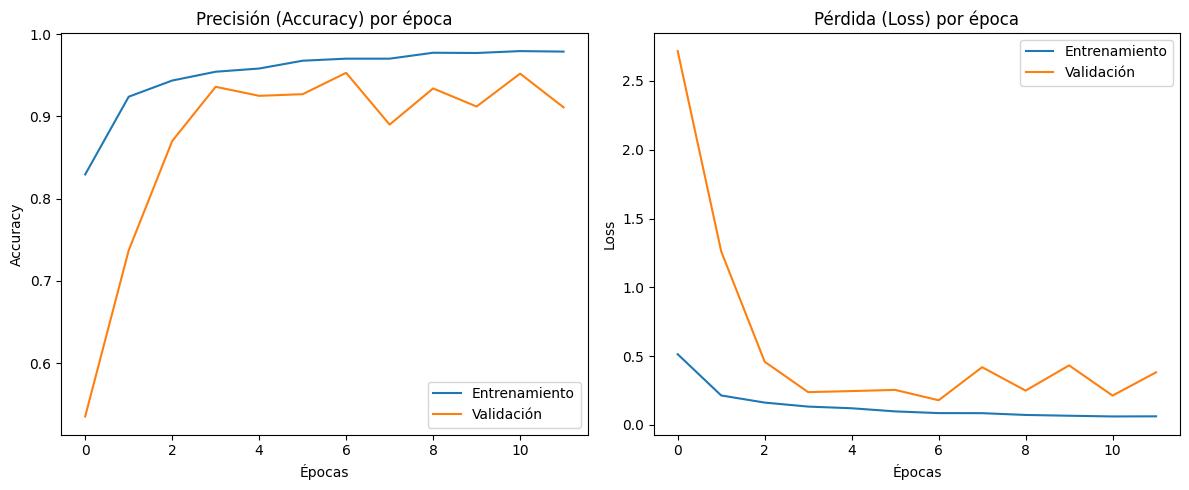

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(historial.history["accuracy"], label="Entrenamiento")
plt.plot(historial.history["val_accuracy"], label="Validación")
plt.title("Precisión (Accuracy) por época")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(historial.history["loss"], label="Entrenamiento")
plt.plot(historial.history["val_loss"], label="Validación")
plt.title("Pérdida (Loss) por época")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Matriz de confusión
Objetivo: ver si el modelo confunde unas clases con otras.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316

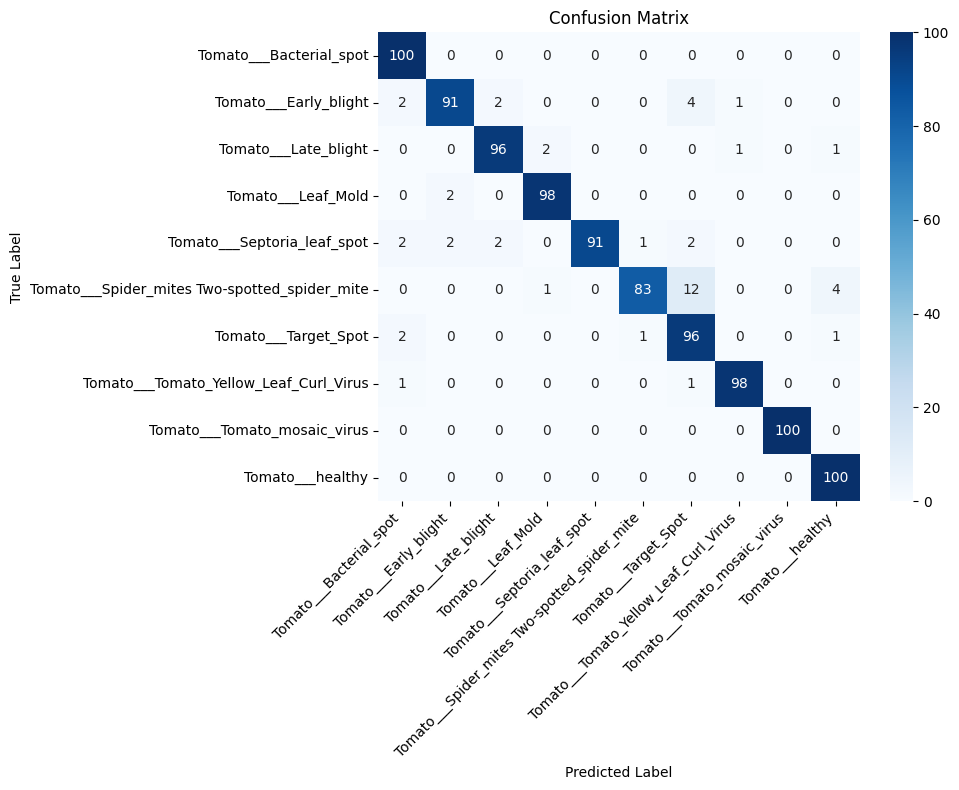

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Precision, Recall y F1-score por clase
Objetivo: ver qué tan bien predice cada enfermedad.
- TP (True Positives) = ? → aciertos (posición [i][i])

- FP (False Positives) = suma de columna [i], excepto la celda [i][i]

- FN (False Negatives) = suma de fila [i], excepto la celda [i][i]

- Precision = TP / (TP + FP)

- Recall = TP / (TP + FN)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.93      1.00      0.97       100
                        Tomato___Early_blight       0.96      0.91      0.93       100
                         Tomato___Late_blight       0.96      0.96      0.96       100
                           Tomato___Leaf_Mold       0.97      0.98      0.98       100
                  Tomato___Septoria_leaf_spot       1.00      0.91      0.95       100
Tomato___Spider_mites Two-spotted_spider_mite       0.98      0.83      0.90       100
                         Tomato___Target_Spot       0.83      0.96      0.89       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.98      0.98       100
                 Tomato___Tomato_mosaic_virus       1.00      1.00      1.00       100
                             Tomato___healthy       0.94      1.00      0.97       100

                                     accu